In [1]:
!pip install eli5
!pip install optuna
!pip install vmdpy

In [2]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from scipy import stats
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import os, glob                       # create folders
from pathlib import Path        # create folders
import pytz   # read time zones

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from vmdpy import VMD


In [3]:
df = pd.read_csv("/Users/palhares/Documents/msc/blood-pressure-estimation/.waves.nosync/physionet.org/files/mimic4wdb/0.1.0/waves/p130/p13016481/81250824/81250824n.csv.gz", compression='gzip')

In [4]:
df

,time,ABPd [mmHg],ABPm [mmHg],ABPs [mmHg],DeltaQTc [msec],HR [bpm],NBPd [mmHg],NBPm [mmHg],NBPs [mmHg],PVC [/min],...,Pulse (NBP) [bpm],Pulse (SpO2) [bpm],QT [msec],QT-HR [bpm],QTc [msec],RR [rpm],ST-III [mm],ST-V [mm],SpO2 [%],btbHR [bpm]
0,79761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.84
1,80357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.67
2,80953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.67
3,81551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.42
4,82148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552364,200810176,NaN,NaN,NaN,-34.0,117.0,NaN,NaN,NaN,0.0,...,NaN,120.0,328.0,120.0,464.0,21.0,0.2,0.0,94.9,NaN
552365,200810206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.00
552366,200810711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.93
552367,200811200,NaN,NaN,NaN,-34.0,117.0,NaN,NaN,NaN,0.0,...,NaN,120.0,328.0,120.0,464.0,25.0,0.2,0.0,95.2,NaN


<AxesSubplot:xlabel='time', ylabel='ABPs [mmHg]'>

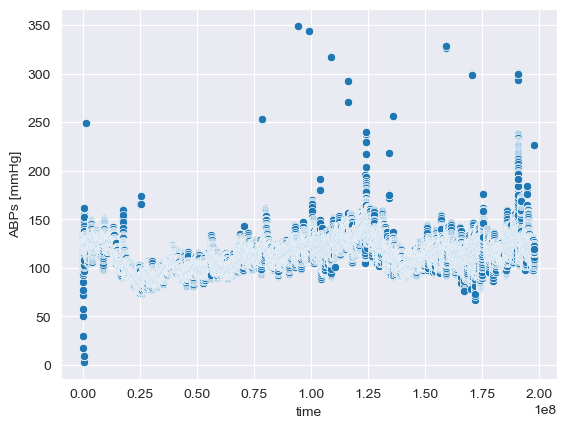

In [5]:
sns.scatterplot(data=df, x="time", y="ABPs [mmHg]")

In [15]:
df.index

RangeIndex(start=0, stop=552369, step=1)

In [6]:
pd.to_timedelta(df["time"], "ms")

0        0 days 00:01:19.761000
1        0 days 00:01:20.357000
2        0 days 00:01:20.953000
3        0 days 00:01:21.551000
4        0 days 00:01:22.148000
                  ...          
552364   2 days 07:46:50.176000
552365   2 days 07:46:50.206000
552366   2 days 07:46:50.711000
552367   2 days 07:46:51.200000
552368   2 days 07:46:51.212000
Name: time, Length: 552369, dtype: timedelta64[ns]

In [7]:
df.index = pd.to_timedelta(df["time"], "ms")

In [10]:
df["sum"] = df["ABPs [mmHg]"].resample("1S").sum()

<AxesSubplot:xlabel='time', ylabel='sum'>

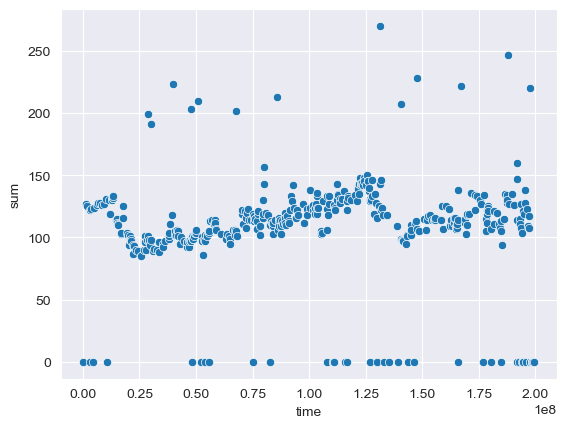

In [12]:
sns.scatterplot(data=df, x="time", y="sum")

In [15]:
new_df = pd.DataFrame(columns=["New"])
new_df["sum"] = df["ABPs [mmHg]"].resample("1S").sum()
new_df.index = df["ABPs [mmHg]"].resample("1S").sum().index

/Users/palhares/opt/anaconda3/envs/msc/lib/python3.8/site-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


ValueError: Could not interpret value `time` for parameter `x`

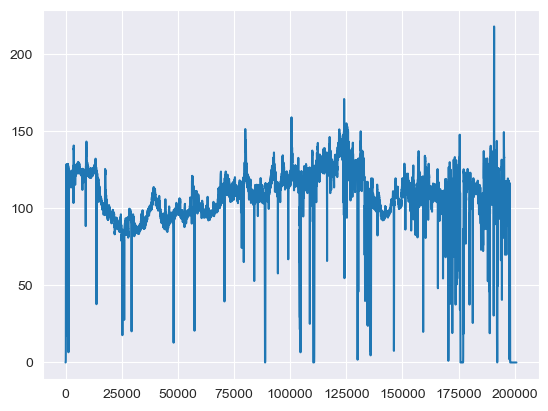

In [18]:
def smoother_data(df):
    #. some sample parameters for VMD
    alpha = 10000       # moderate bandwidth constraint
    tau = 0.            # noise-tolerance (no strict fidelity enforcement)
    K = 8              # 8 modes
    DC = 1             # no DC part imposed
    init = 1           # initialize omegas uniformly
    tol = 1e-7

    #. Run VMD
    u, u_hat, omega = VMD(df["sum"], alpha, tau, K, DC, init, tol)
    df["ABPs [mmHg] smooth"] = df["sum"].mean()
    # try:
    #     df["ABPs [mmHg] smooth"].iloc[1:] = u[0]
    # except:
    #     df["ABPs [mmHg] smooth"].iloc[:] = u[0]

    return u[0]
test_df = smoother_data(new_df)
plt.plot(np.arange(len(test_df)), test_df)
#sns.scatterplot(data=test_df, x="time", y="ABPs [mmHg] smooth")